In [1]:
import sys
import pathlib

ROOT = pathlib.Path(".").absolute().parent.parent
sys.path.append(str(ROOT))

In [2]:
import pytorch_lightning as pl
from models.raw_audio import ResTSSDNetWrapper
from models.raw_audio import IncTSSDNetWrapper
from datasets.SPCUP22DataModule import SPCUP22DataModule
import torch.nn.functional as F
import scikitplot as skplt
import matplotlib.pyplot as plt

/home/iubnlp/anaconda3/envs/spcup2022/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def plot_classification_report(
    actual_labels,
    predicted_labels,
    predicted_probabilities,
    title_suffix,
    figsize=(30, 10),
):
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=figsize, dpi=300)
    axes = list(axes.flatten())

    skplt.metrics.plot_confusion_matrix(
        actual_labels,
        predicted_labels,
        title="Confusion Matrix: {}".format(title_suffix),
        ax=axes[0],
    )

    skplt.metrics.plot_precision_recall_curve(
        actual_labels,
        predicted_probabilities,
        title="Precision-Recall Curve: {}".format(title_suffix),
        figsize=(6, 6),
        ax=axes[1],
    )

    skplt.metrics.plot_roc_curve(
        actual_labels,
        predicted_probabilities,
        title="ROC Curve: {}".format(title_suffix),
        figsize=(6, 6),
        ax=axes[2],
    )

    return fig, axes


In [4]:
def make_predictions(checkpoint, data_module):
    checkpoint.eval()
    trainer = pl.Trainer(gpus=[4])
    predictions = trainer.predict(checkpoint, datamodule=data_module)
    
    flattened_predictions = []
    flattened_probabilities = []
    
    for batch in predictions:
        for prediction in batch:
            softmax_probabilities = F.softmax(prediction)
            predicted_label = softmax_probabilities.argmax(dim=0)
            flattened_predictions.append(predicted_label.item())
            flattened_probabilities.append(softmax_probabilities.tolist())

    actual_labels = []

    for data in data_module.test_data:
        actual_labels.append(data[-1])

    return actual_labels, flattened_predictions, flattened_probabilities  
    

In [5]:
checkpoint = IncTSSDNetWrapper.load_from_checkpoint(
    "/home/iubnlp/spcup22/SPCUP2022/checkpoints/inc_tssdnet/last.ckpt"
)
data_module = SPCUP22DataModule(64, dataset_root=pathlib.Path(ROOT).joinpath("data", "spcup22"))

In [6]:
actual_labels, predictions, probabilities = make_predictions(
    checkpoint, data_module
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/spcup22/spcup_2022_training_part1.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/spcup22/spcup_2022_unseen.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/spcup22/spcup_2022_eval_part1.zip]...
Predicting: 100%|██████████| 16/16 [00:02<00:00,  7.43it/s]


/home/iubnlp/anaconda3/envs/spcup2022/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


/home/iubnlp/anaconda3/envs/spcup2022/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)
/home/iubnlp/anaconda3/envs/spcup2022/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


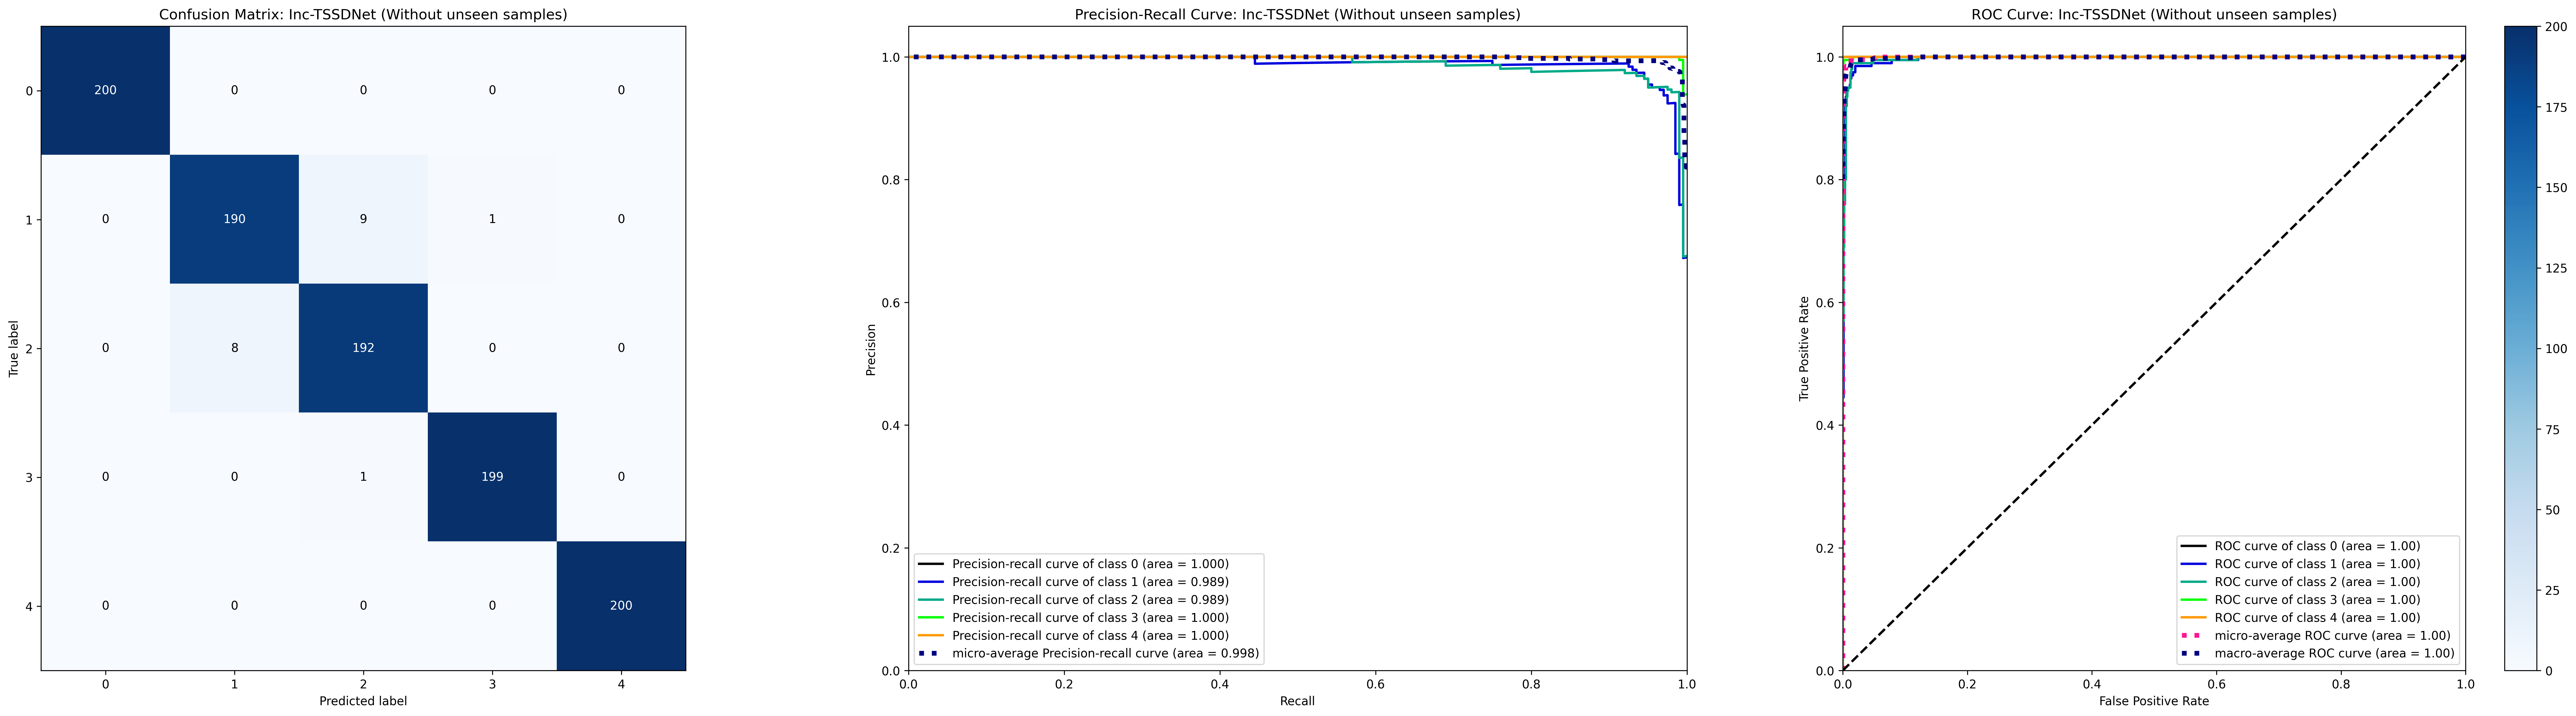

In [7]:
fig, axes = plot_classification_report(
    actual_labels,
    predictions,
    probabilities,
    title_suffix="Inc-TSSDNet (Without unseen samples)",
    figsize=(40, 10)
)


In [8]:
checkpoint = ResTSSDNetWrapper.load_from_checkpoint(
    "/home/iubnlp/spcup22/SPCUP2022/checkpoints/res_tssdnet/last.ckpt"
)
data_module = SPCUP22DataModule(64, dataset_root=pathlib.Path(ROOT).joinpath("data", "spcup22"))

In [9]:
actual_labels, predictions, probabilities = make_predictions(
    checkpoint, data_module
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/spcup22/spcup_2022_training_part1.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/spcup22/spcup_2022_unseen.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/spcup22/spcup_2022_eval_part1.zip]...
Predicting: 100%|██████████| 16/16 [00:02<00:00,  5.76it/s]


/home/iubnlp/anaconda3/envs/spcup2022/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


/home/iubnlp/anaconda3/envs/spcup2022/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)
/home/iubnlp/anaconda3/envs/spcup2022/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


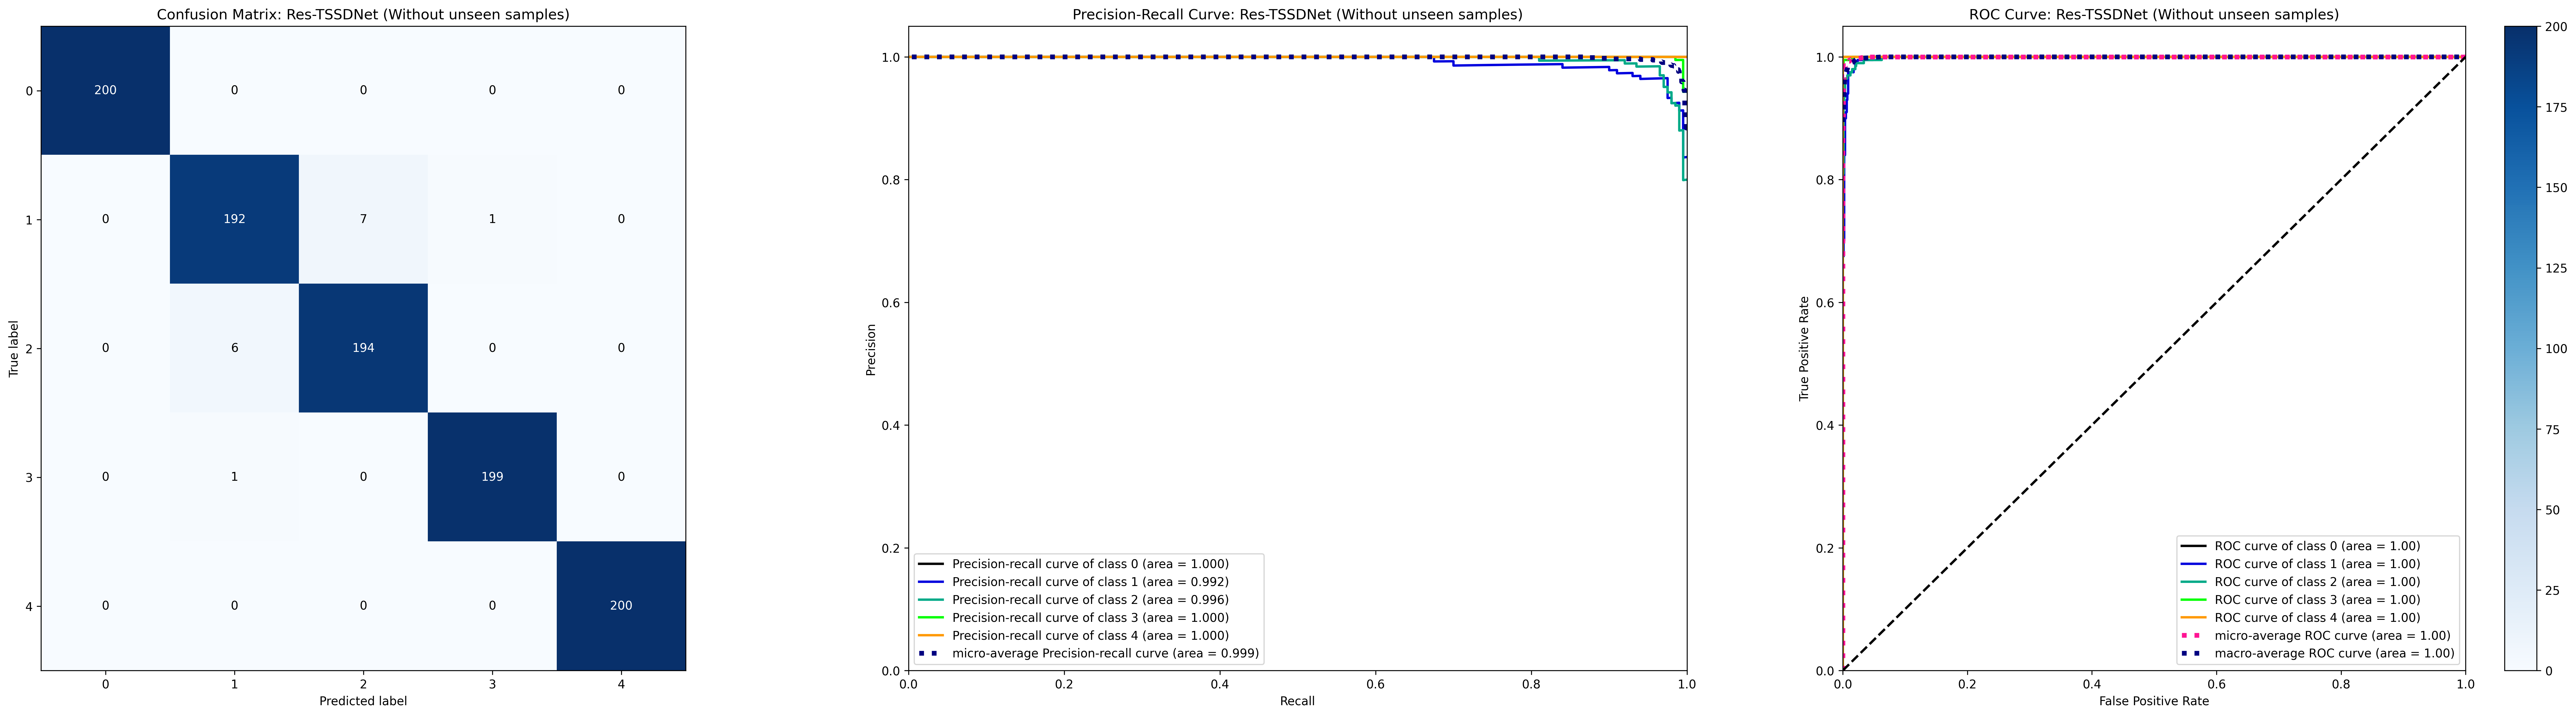

In [10]:
fig, axes = plot_classification_report(
    actual_labels,
    predictions,
    probabilities,
    title_suffix="Res-TSSDNet (Without unseen samples)",
    figsize=(40, 10)
)

In [11]:
checkpoint = IncTSSDNetWrapper.load_from_checkpoint(
    "/home/iubnlp/spcup22/SPCUP2022/checkpoints/inc_tssdnet_with_unseen/last.ckpt"
)
data_module = SPCUP22DataModule(
    64,
    dataset_root=pathlib.Path(ROOT).joinpath("data", "spcup22"),
    should_include_unseen_in_training_data=True,
)

In [12]:
actual_labels, predictions, probabilities = make_predictions(
    checkpoint, data_module
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/spcup22/spcup_2022_training_part1.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/spcup22/spcup_2022_unseen.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/spcup22/spcup_2022_eval_part1.zip]...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 100%|██████████| 19/19 [00:03<00:00,  5.97it/s]


/home/iubnlp/anaconda3/envs/spcup2022/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


/home/iubnlp/anaconda3/envs/spcup2022/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)
/home/iubnlp/anaconda3/envs/spcup2022/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


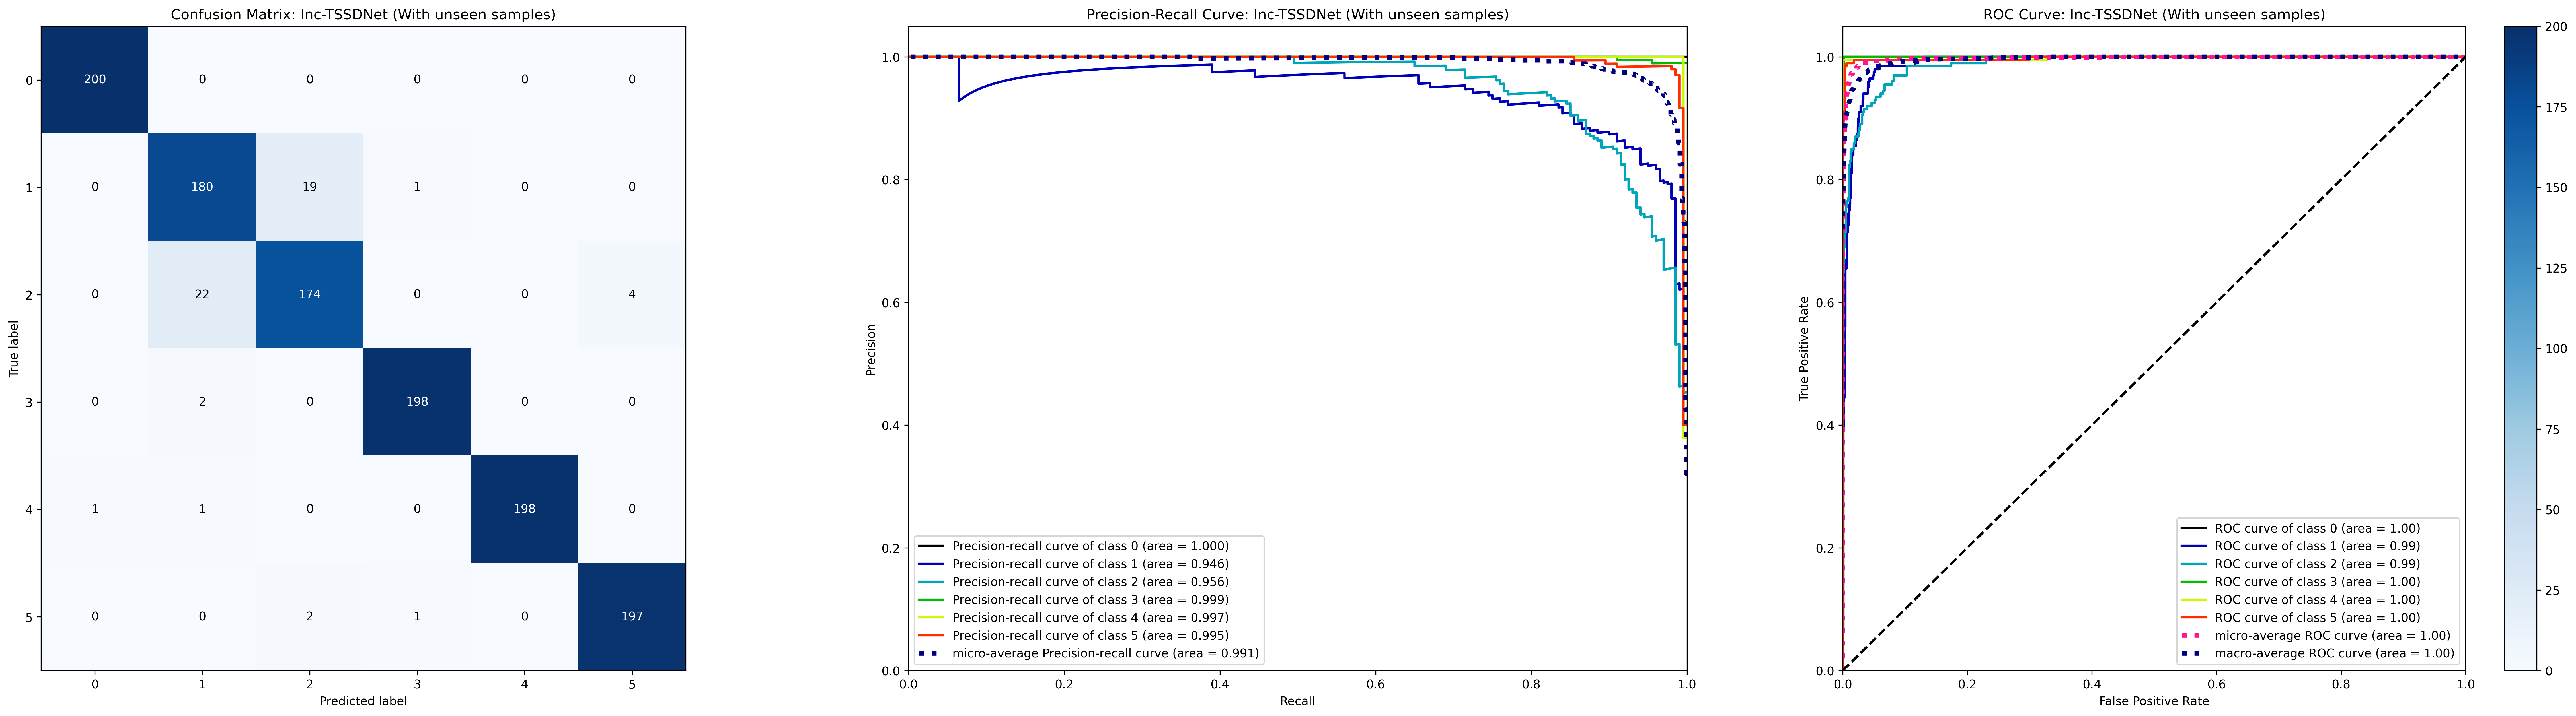

In [13]:
fig, axes = plot_classification_report(
    actual_labels,
    predictions,
    probabilities,
    title_suffix="Inc-TSSDNet (With unseen samples)",
    figsize=(40, 10)
)

In [14]:
checkpoint = ResTSSDNetWrapper.load_from_checkpoint(
    "/home/iubnlp/spcup22/SPCUP2022/checkpoints/res_tssdnet_with_unseen/last.ckpt"
)
data_module = SPCUP22DataModule(
    64,
    dataset_root=pathlib.Path(ROOT).joinpath("data", "spcup22"),
    should_include_unseen_in_training_data=True,
)

In [15]:
actual_labels, predictions, probabilities = make_predictions(
    checkpoint, data_module
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/spcup22/spcup_2022_training_part1.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/spcup22/spcup_2022_unseen.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/spcup22/spcup_2022_eval_part1.zip]...
Predicting: 100%|██████████| 19/19 [00:03<00:00,  5.38it/s]


/home/iubnlp/anaconda3/envs/spcup2022/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


/home/iubnlp/anaconda3/envs/spcup2022/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)
/home/iubnlp/anaconda3/envs/spcup2022/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


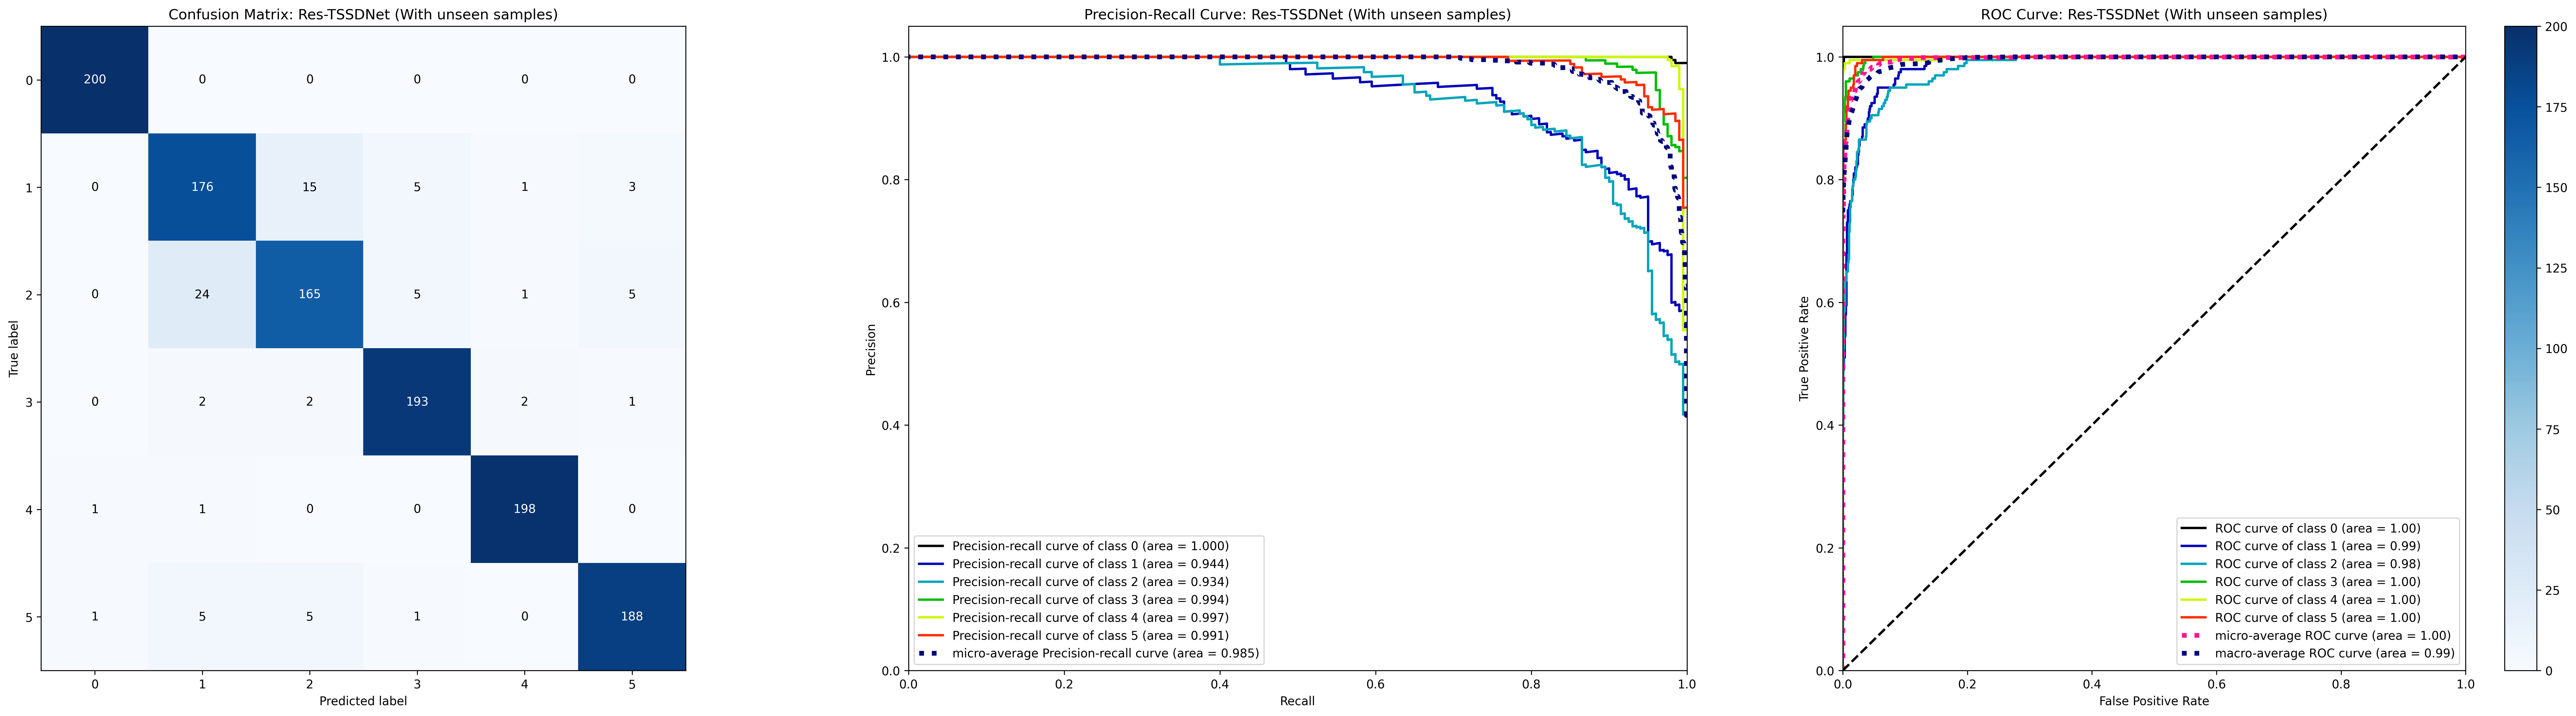

In [16]:
fig, axes = plot_classification_report(
    actual_labels,
    predictions,
    probabilities,
    title_suffix="Res-TSSDNet (With unseen samples)",
    figsize=(40, 10)
)